# Decision Trees

Decision trees are one of the most intuitive and interpretable machine learning algorithms, making them excellent tools for both classification and regression tasks.

## What is a Decision Tree?

A decision tree is a flowchart-like structure where:
- Each **internal node** represents a "test" on an attribute/feature (e.g., whether a car's horsepower is larger than 200)
- Each **branch** represents the outcome of that test
- Each **leaf node** represents a final decision or prediction (class label for classification, value for regression)
- The **paths from root to leaf** represent the decision rules learned from the data

## Key Advantages

1. **Interpretability**: Easy to understand and visualize, even for non-technical stakeholders
2. **No feature scaling required**: Works well with features on different scales
3. **Handles both numerical and categorical data**: Flexible input requirements
5. **Feature interactions**: Automatically captures interactions between features

## Key Disadvantages

The biggest disadvantage of decision trees is that they are prone to overfitting.
A deep decision tree can fit the training data extremely well, by effectively memorizing the training data.
However, this is the trademark of overfitting, and we need to use techniques like cross-validation 
to evaluate the generalization performance of the model.

In [1]:
# Standard imports for data manipulation and visualization
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure seaborn for better-looking plots
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

## Loss Functions for Classification

Decision tree algorithms need a way to determine the quality of a split. They use criteria or measures (loss functions) to evaluate different potential splits and choose the one that best separates the classes.

### Three Common Split Criteria

1. **Classification Error Rate**: 
   - Measures the fraction of misclassified samples. 
   - Formula: $E = 1 - \max_i(p_i)$ where $p_i$ is the proportion of class $i$
   - Simple but not sensitive enough to make good splits.

2. **Gini Index (Gini Impurity)**: 
   - Measures the probability of incorrectly classifying a randomly chosen element.
   - Formula: $G = \sum_{i=1}^{C} p_i(1-p_i) = 1 - \sum_{i=1}^{C} p_i^2$
   - Lower values indicate purer nodes (better splits)

3. **Entropy (Information Gain)**: 
   - Measures the level of impurity or uncertainty in the data. Based on information theory.
   - Formula: $H = -\sum_{i=1}^{C} p_i \log_2(p_i)$
   - The split that provides the highest information gain (reduction in entropy) is chosen

For binary classification, we can visualize how these metrics vary with the class ratio: 

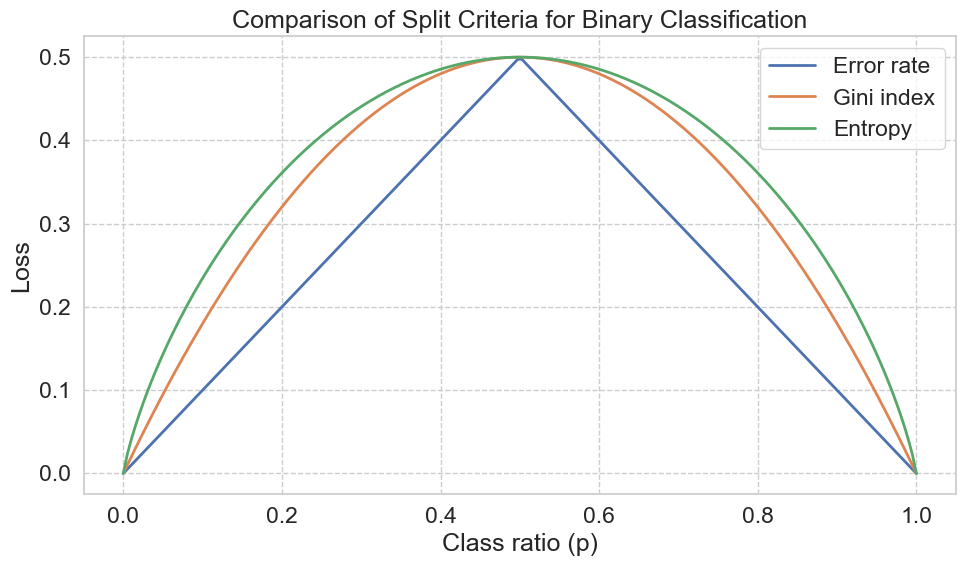

In [2]:
def error_rate(p: float):
    """Calculates classification error rate for a given binary class ratio.

    For binary classification, error rate is the minimum of p and 1-p,
    representing the fraction of misclassified samples if we predict
    the majority class.
    """
    return p if p < 0.5 else 1 - p

def gini_index(p: float):
    """Calculates Gini index for a given binary class ratio.

    Gini index measures impurity. For binary classification:
    G = 2 * p * (1-p), where p is the proportion of one class.
    It reaches maximum (0.5) when classes are perfectly balanced (p=0.5)
    and minimum (0) when the node is pure (p=0 or p=1).
    """
    return 2 * p * (1 - p)

def entropy(p: float):
    """Calculates entropy for a given binary class ratio, normalized by ln(2).

    Entropy measures the amount of information or uncertainty.
    For binary classification: H = -p*log2(p) - (1-p)*log2(1-p).
    We add a small epsilon (1e-16) to avoid log(0).
    The normalization ensures values are comparable to Gini index.
    """
    scale = 0.5 / np.log(2)
    return -(p * np.log(p + 1e-16) + (1 - p) * np.log(1 - p + 1e-16)) * scale

# Generate p values from 0 to 1 to visualize the loss functions
p = np.linspace(start=0, stop=1, num=200)

# Create comparison plot of the three loss functions
plt.figure(figsize=(10, 6))
sns.lineplot(x=p, y=[error_rate(x) for x in p], label="Error rate", linewidth=2)
sns.lineplot(x=p, y=[gini_index(x) for x in p], label="Gini index", linewidth=2)
sns.lineplot(x=p, y=[entropy(x) for x in p], label="Entropy", linewidth=2)

plt.ylabel("Loss")
plt.xlabel("Class ratio (p)")
plt.title("Comparison of Split Criteria for Binary Classification")
plt.tight_layout()
plt.show()

# Note: All three functions reach their maximum at p=0.5 (balanced classes)
# and minimum at p=0 or p=1 (pure nodes). Gini and Entropy are more sensitive
# to changes in class distribution, making them preferred for tree building.

## Binary Classification Example

Now let's apply decision trees to a real-world problem. We'll use the same **Breast Cancer Wisconsin dataset**, 
which we have used in the previous lectures.

In [3]:
# Load the breast cancer dataset from GitHub
cancer = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/breast_cancer.csv")

# Create a binary label: 0 for Benign (B), 1 for Malignant (M)
cancer["label"] = cancer["diagnosis"].apply(lambda x: 0 if x == "B" else 1)

# Display the first few rows to understand the data structure
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_mean,...,texture_extreme,perimeter_extreme,area_extreme,smoothness_extreme,compactness_extreme,concavity_extreme,concave_extreme,symmetry_extreme,fractal_extreme,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [4]:
# Import the decision tree module from scikit-learn
from sklearn import tree

# Create a decision tree classifier with specific hyperparameters
dt_model = tree.DecisionTreeClassifier(
    criterion="gini",  # Use Gini impurity as the split criterion
    max_depth=3,  # Limit tree depth to 3 levels to prevent overfitting
)

# Define all 30 features from the breast cancer dataset
# These are organized into three groups: mean, standard error (se), and extreme values
features = [
    # Mean values of cell nucleus measurements
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave_mean",
    "symmetry_mean",
    "fractal_mean",
    # Standard errors of the measurements
    "radius_se",
    "texture_se",
    "perimeter_se",
    "area_se",
    "smoothness_se",
    "compactness_se",
    "concavity_se",
    "concave_se",
    "symmetry_se",
    "fractal_se",
    # Worst (extreme) values of the measurements
    "radius_extreme",
    "texture_extreme",
    "perimeter_extreme",
    "area_extreme",
    "smoothness_extreme",
    "compactness_extreme",
    "concavity_extreme",
    "concave_extreme",
    "symmetry_extreme",
    "fractal_extreme",
]

# Define the target variable (label)
label = "label"

# Train the decision tree on the entire dataset
# Note: In practice, we should split data into train/test sets (we'll do this later)
dt_model.fit(X=cancer[features], y=cancer[label])

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


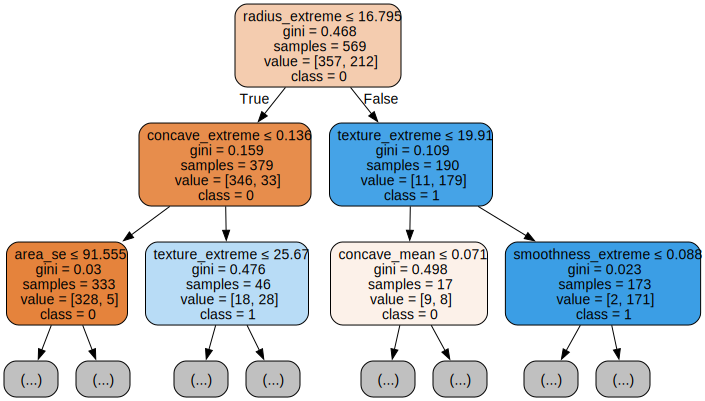

In [5]:
# Import graphviz for tree visualization
import graphviz

# Export the decision tree to DOT format for visualization
dot_data = tree.export_graphviz(
    decision_tree=dt_model,  # The trained decision tree model
    out_file=None,  # Return as string instead of writing to file
    feature_names=features,  # Use actual feature names instead of generic X[0], X[1]
    class_names=["0", "1"],  # Label the classes for better interpretability
    filled=True,  # Color nodes by class majority
    rounded=True,  # Use rounded boxes for better aesthetics
    special_characters=True,  # Allow special characters in labels
    max_depth=2,  # Only show first 2 levels for readability
)

# Create a graphviz object from the DOT data
graph = graphviz.Source(dot_data)

# Save the tree visualization to a file (optional)
graph.render("cancer_tree")

# Display the tree in the notebook
graph

## Advanced Topics

Now that we've built a basic decision tree, let's explore more advanced concepts including:
1. **Model Evaluation**: Assessing performance using proper train/test splits
2. **Overfitting vs. Underfitting**: Understanding the impact of tree depth
3. **Feature Importance**: Identifying which features matter most
4. **Comparison with Other Models**: How does the decision tree compare to logistic regression?
5. **Hyperparameter Tuning**: Exploring key parameters that control tree complexity


### 1. Model Evaluation with Train/Test Split

Previously, we trained on the entire dataset, which doesn't give us a fair assessment of how the model generalizes to new data. Let's properly split the data and evaluate performance using multiple metrics.

#### Key Evaluation Metrics

**Accuracy**: The proportion of correct predictions. While intuitive, it can be misleading with imbalanced datasets.

**Precision & Recall**: 
- **Precision**: Of all positive predictions, how many were correct? (TP / (TP + FP))
- **Recall (Sensitivity)**: Of all actual positives, how many did we catch? (TP / (TP + FN))

**F1-Score**: Harmonic mean of precision and recall, balancing both metrics.

**AUC-ROC (Area Under the ROC Curve)**: 
- Measures the model's ability to distinguish between classes across all classification thresholds
- Ranges from 0 to 1 (higher is better, 0.5 = random guessing)
- **Threshold-independent**: Unlike accuracy, it evaluates all possible classification thresholds
- **Robust to class imbalance**: More reliable than accuracy when classes are imbalanced
- Particularly valuable in medical contexts where we need to understand the tradeoff between sensitivity and specificity


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# Split the data into training (80%) and testing (20%) sets
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    cancer[features],
    cancer[label],
    test_size=0.2,
    random_state=42,
    stratify=cancer[label]  # Maintain class distribution in both sets
)

# Train a new decision tree on the training data
dt_model_eval = tree.DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    random_state=42
)
dt_model_eval.fit(X_train, y_train)

# Make predictions on both training and test sets
y_train_pred = dt_model_eval.predict(X_train)
y_test_pred = dt_model_eval.predict(X_test)

# Get probability predictions for AUC-ROC calculation
# predict_proba returns probabilities for each class [P(class=0), P(class=1)]
y_train_proba = dt_model_eval.predict_proba(X_train)[:, 1]  # Probability of class 1 (Malignant)
y_test_proba = dt_model_eval.predict_proba(X_test)[:, 1]

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate AUC-ROC scores
# AUC-ROC is threshold-independent and ranges from 0 to 1 (higher is better)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Difference (Train - Test): {train_accuracy - test_accuracy:.4f}")
print(f"\nTraining AUC-ROC: {train_auc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Difference (Train - Test): {train_auc - test_auc:.4f}")


Training Accuracy: 0.9670
Test Accuracy: 0.9035
Difference (Train - Test): 0.0635

Training AUC-ROC: 0.9725
Test AUC-ROC: 0.8750
Difference (Train - Test): 0.0975


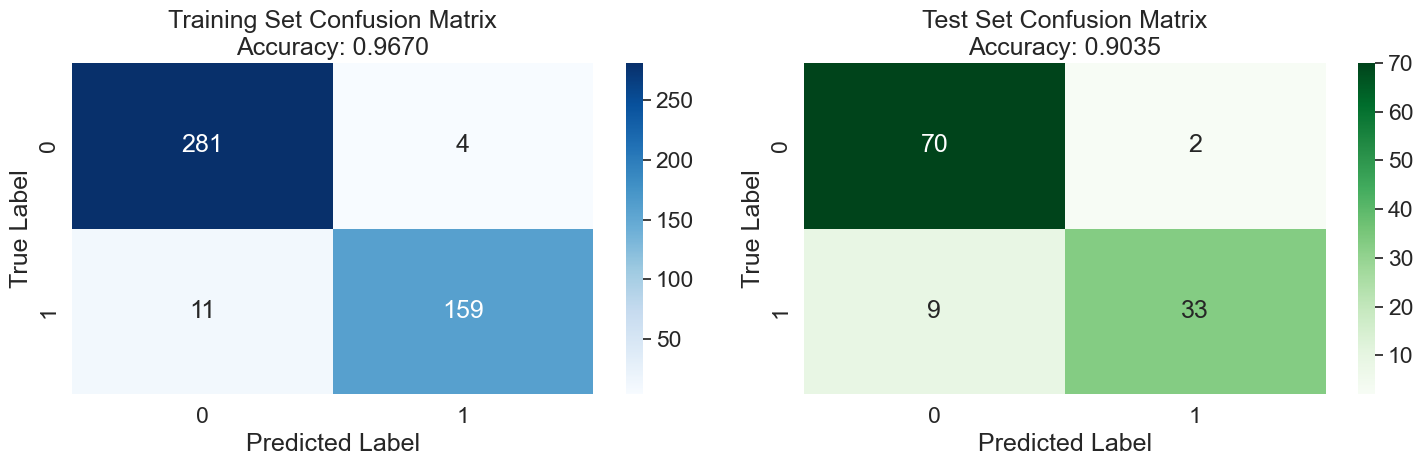

In [7]:
# Visualize confusion matrices for both training and test sets
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training confusion matrix
sns.heatmap(
    cm_train,
    annot=True,           # Show numbers in cells
    fmt="d",              # Display as integers
    cmap="Blues",         # Color scheme
    xticklabels=["0", "1"],
    yticklabels=["0", "1"],
    ax=axes[0]
)
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
axes[0].set_title(f"Training Set Confusion Matrix\nAccuracy: {train_accuracy:.4f}")

# Test confusion matrix
sns.heatmap(
    cm_test,
    annot=True,           # Show numbers in cells
    fmt="d",              # Display as integers
    cmap="Greens",        # Different color to distinguish from training
    xticklabels=["0", "1"],
    yticklabels=["0", "1"],
    ax=axes[1]
)
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")
axes[1].set_title(f"Test Set Confusion Matrix\nAccuracy: {test_accuracy:.4f}")

plt.tight_layout()
plt.show()


### 2. Overfitting vs. Underfitting: The Role of Tree Depth

One of the most important hyperparameters in decision trees is `max_depth`, which controls how deep the tree can grow. Let's explore how this affects model performance:

- **Shallow trees (small `max_depth`)**: May underfit, missing important patterns
- **Deep trees (large `max_depth`)**: May overfit, memorizing training data instead of learning general patterns

We'll train multiple trees with different depths and compare their performance.


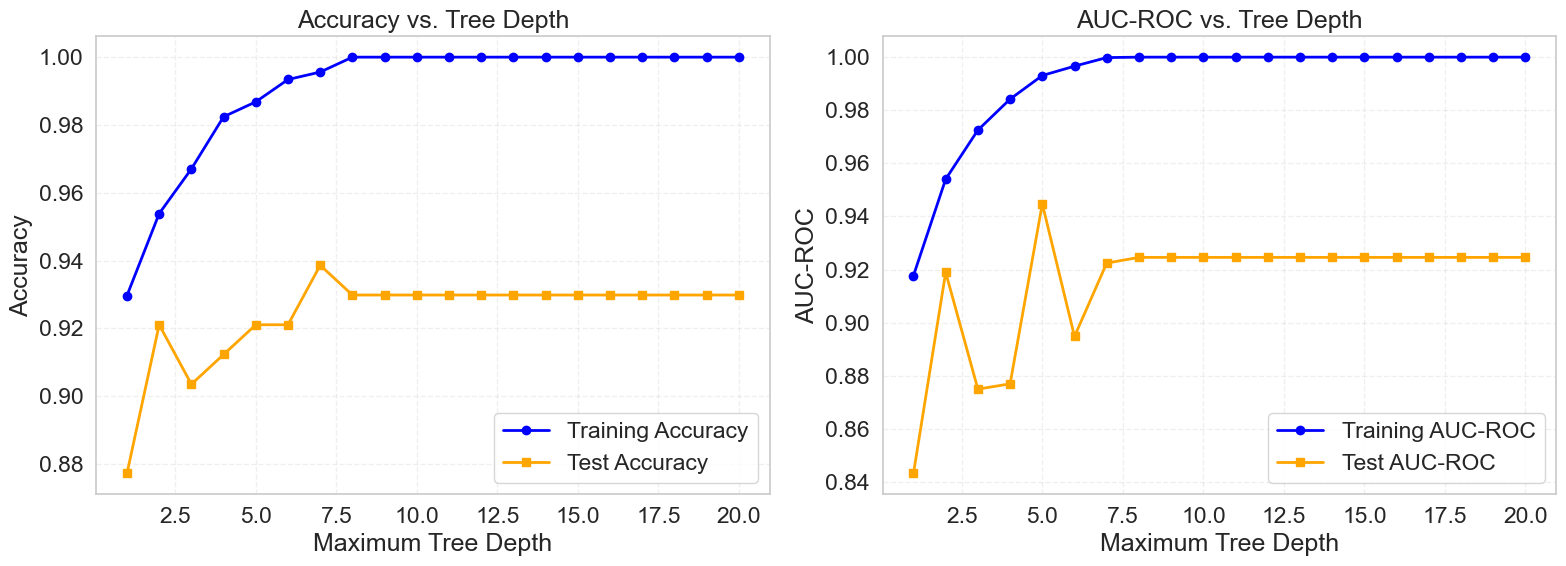

In [8]:
# Test a range of max_depth values
max_depths = range(1, 21)  # Test depths from 1 to 20
train_acc_scores = []
test_acc_scores = []
train_auc_scores = []
test_auc_scores = []

# Train a model for each depth and record performance
for depth in max_depths:
    # Create and train the model
    dt = tree.DecisionTreeClassifier(
        criterion="gini",
        max_depth=depth,
        random_state=42
    )
    dt.fit(X_train, y_train)

    # Calculate and store accuracies
    train_acc_scores.append(accuracy_score(y_train, dt.predict(X_train)))
    test_acc_scores.append(accuracy_score(y_test, dt.predict(X_test)))

    # Calculate and store AUC-ROC scores
    train_auc_scores.append(roc_auc_score(y_train, dt.predict_proba(X_train)[:, 1]))
    test_auc_scores.append(roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1]))

# Visualize the results with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Accuracy
axes[0].plot(max_depths, train_acc_scores, marker="o", label="Training Accuracy", linewidth=2, color="blue")
axes[0].plot(max_depths, test_acc_scores, marker="s", label="Test Accuracy", linewidth=2, color="orange")
axes[0].set_xlabel("Maximum Tree Depth")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy vs. Tree Depth")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subplot 2: AUC-ROC
axes[1].plot(max_depths, train_auc_scores, marker="o", label="Training AUC-ROC", linewidth=2, color="blue")
axes[1].plot(max_depths, test_auc_scores, marker="s", label="Test AUC-ROC", linewidth=2, color="orange")
axes[1].set_xlabel("Maximum Tree Depth")
axes[1].set_ylabel("AUC-ROC")
axes[1].set_title("AUC-ROC vs. Tree Depth")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3. Feature Importance Analysis

One of the great advantages of decision trees is that they naturally provide feature importance scores. These scores tell us which features were most useful in making predictions.

#### How Feature Importance is Calculated

**Basic Principle**: Features used in splits near the root of the tree (which separate large groups of samples) are considered more important than features used in splits near the leaves.

**Mathematical Formula**: For each feature $j$, the importance is calculated as:

$$\text{Importance}(j) = \sum_{t \in \text{nodes using feature } j} \frac{n_t}{N} \cdot \Delta I(t)$$

Where:
- $n_t$ = number of samples reaching node $t$
- $N$ = total number of samples
- $\Delta I(t)$ = impurity decrease at node $t$

**The impurity decrease** at a node is:

$$\Delta I(t) = I(t) - \frac{n_\text{left}}{n_t} \cdot I(t_\text{left}) - \frac{n_\text{right}}{n_t} \cdot I(t_\text{right})$$

Where $I(t)$ is the impurity (Gini or entropy) at node $t$, and $n_\text{left}$, $n_\text{right}$ are the number of samples in the left and right child nodes.

**Key Points**:
1. **Weighted by sample size**: Splits affecting more samples contribute more to importance
2. **Measured by impurity reduction**: Splits that better separate classes have higher importance
3. **Normalized**: All importance values sum to 1.0, making them easy to interpret as percentages
4. **Zero importance**: Features never used in any split have importance = 0


Total importance (should be 1.0): 1.0000000000
This confirms that importances are normalized and can be interpreted as percentages.

Top 15 Most Important Features:
            Feature  Importance
  perimeter_extreme    0.820460
    concave_extreme    0.077068
       texture_mean    0.048457
          area_mean    0.025559
       area_extreme    0.017766
    texture_extreme    0.010691
        radius_mean    0.000000
       concavity_se    0.000000
   symmetry_extreme    0.000000
  concavity_extreme    0.000000
compactness_extreme    0.000000
 smoothness_extreme    0.000000
     radius_extreme    0.000000
         fractal_se    0.000000
        symmetry_se    0.000000

Number of features with zero importance: 24
Number of features with non-zero importance: 6


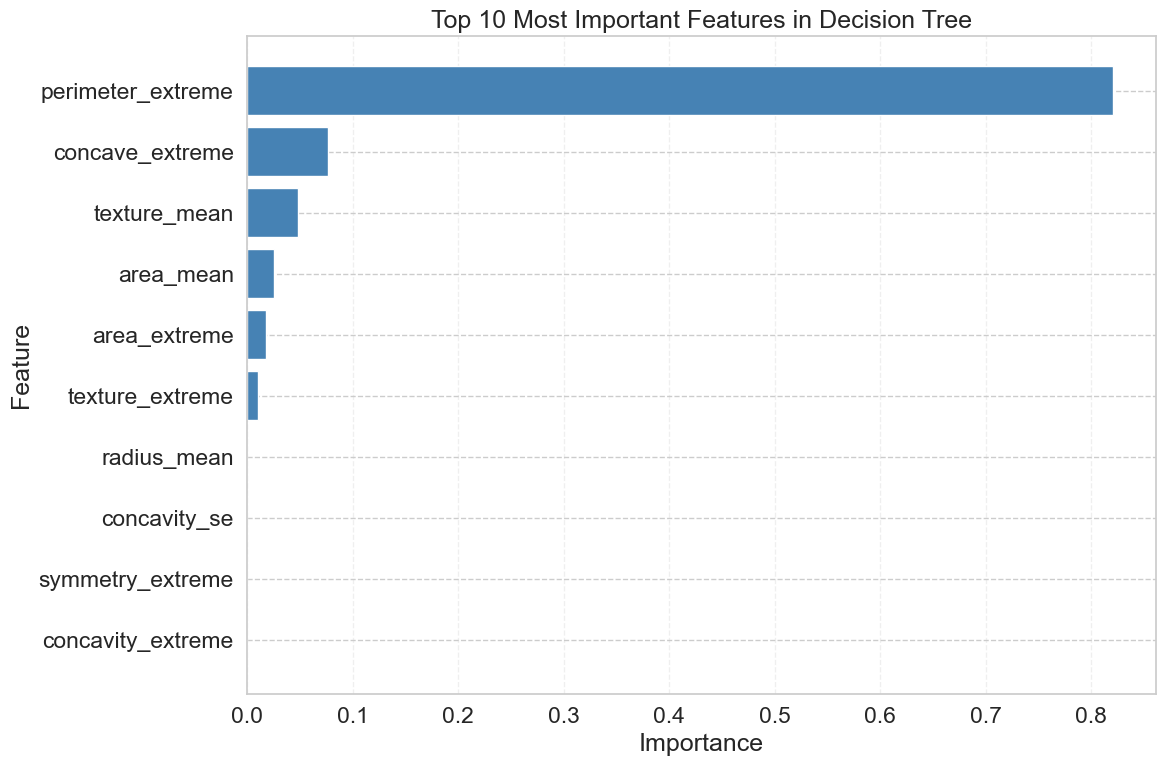

In [9]:
# Extract feature importances from our trained model
feature_importances = dt_model_eval.feature_importances_

# Verify that importances are normalized (sum to 1.0)
total_importance = np.sum(feature_importances)
print(f"Total importance (should be 1.0): {total_importance:.10f}")
print(f"This confirms that importances are normalized and can be interpreted as percentages.\n")

# Create a DataFrame for easier manipulation and visualization
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances,
}).sort_values("Importance", ascending=False)

# Display top 15 most important features
print("Top 15 Most Important Features:")
print("="*70)
print(importance_df.head(15).to_string(index=False))
print(f"\nNumber of features with zero importance: {(importance_df['Importance'] == 0).sum()}")
print(f"Number of features with non-zero importance: {(importance_df['Importance'] > 0).sum()}")

# Visualize the top 10 features
plt.figure(figsize=(12, 8))
top_n = 10
top_features = importance_df.head(top_n)
plt.barh(range(top_n), top_features["Importance"].values, color="steelblue")
plt.yticks(range(top_n), top_features["Feature"].values)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Most Important Features in Decision Tree")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

### 4. Comparison with Logistic Regression

To put our decision tree's performance in context, let's compare it with a logistic regression model, which we studied earlier in the course. This comparison will help us understand when to use each algorithm.


Model Comparison:
                  Model  Train Accuracy  Test Accuracy  Train AUC-ROC  Test AUC-ROC  Overfitting Gap (Acc)
Decision Tree (depth=3)        0.967033       0.903509       0.972528      0.875000               0.063524
    Logistic Regression        0.986813       0.964912       0.997585      0.996032               0.021901




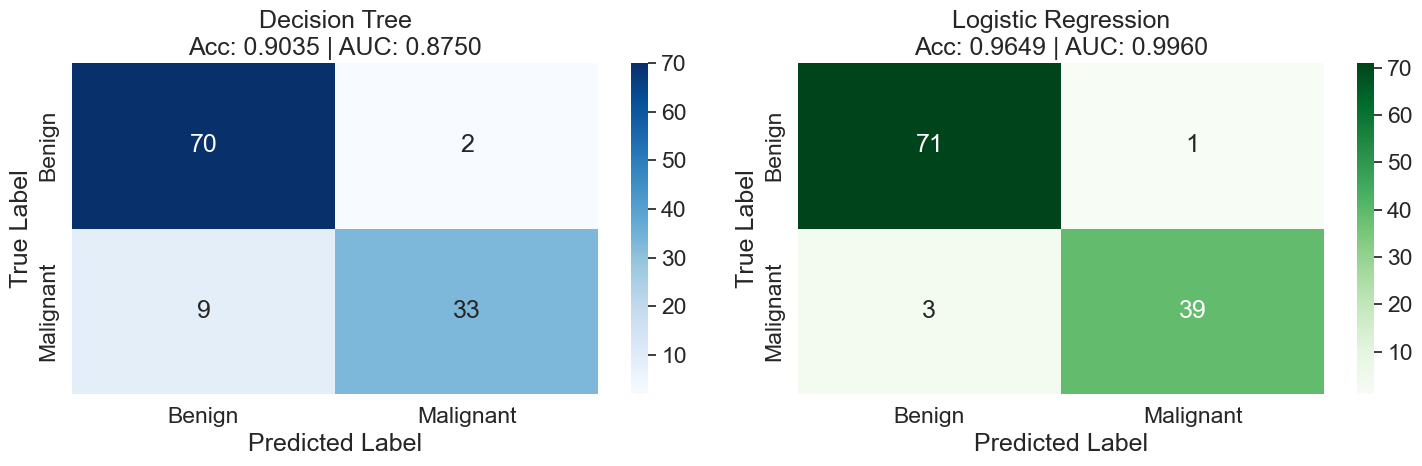

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Logistic regression typically benefits from feature scaling
# Decision trees do NOT require scaling, but we'll scale for fair comparison
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions (class labels)
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Make predictions (probabilities for AUC-ROC)
lr_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracies
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

# Calculate AUC-ROC scores
lr_train_auc = roc_auc_score(y_train, lr_train_proba)
lr_test_auc = roc_auc_score(y_test, lr_test_proba)

# Get decision tree metrics from our previous model
dt_train_acc = train_accuracy
dt_test_acc = test_accuracy
dt_train_auc = train_auc
dt_test_auc = test_auc

# Compare the models
comparison_df = pd.DataFrame({
    "Model": ["Decision Tree (depth=3)", "Logistic Regression"],
    "Train Accuracy": [dt_train_acc, lr_train_acc],
    "Test Accuracy": [dt_test_acc, lr_test_acc],
    "Train AUC-ROC": [dt_train_auc, lr_train_auc],
    "Test AUC-ROC": [dt_test_auc, lr_test_auc],
    "Overfitting Gap (Acc)": [dt_train_acc - dt_test_acc, lr_train_acc - lr_test_acc]
})

print("Model Comparison:")
print("="*90)
print(comparison_df.to_string(index=False))
print("\n")

# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Decision Tree confusion matrix
cm_dt = confusion_matrix(y_test, y_test_pred)
sns.heatmap(
    cm_dt,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
    ax=axes[0]
)
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
axes[0].set_title(f"Decision Tree\nAcc: {dt_test_acc:.4f} | AUC: {dt_test_auc:.4f}")

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, lr_test_pred)
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
    ax=axes[1]
)
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")
axes[1].set_title(f"Logistic Regression\nAcc: {lr_test_acc:.4f} | AUC: {lr_test_auc:.4f}")

plt.tight_layout()
plt.show()


### 5. Hyperparameters and Tree Pruning

Decision trees have several hyperparameters that control their complexity and help prevent overfitting. Understanding these is crucial for building effective models.

#### Key Hyperparameters

1. **max_depth**: Maximum depth of the tree
   - Controls how many questions the tree can ask in sequence
   - Deeper trees can capture more complex patterns but risk overfitting

2. **min_samples_split**: Minimum number of samples required to split an internal node
   - Higher values prevent creating splits based on very few samples
   - Helps prevent overfitting by avoiding too-specific rules

3. **min_samples_leaf**: Minimum number of samples required at a leaf node
   - Ensures each leaf represents a meaningful number of samples
   - Smooths the model and prevents overfitting

4. **max_features**: Number of features to consider when looking for the best split
   - Can speed up training and reduce overfitting
   - Common values: "sqrt" (square root of total features), "log2", or a specific number

5. **criterion**: Function to measure split quality
   - "gini" (default): Gini impurity
   - "entropy": Information gain

Let's experiment with these hyperparameters:


In [11]:
# Compare different hyperparameter configurations
models_config = [
    {"name": "Default (unconstrained)", "params": {}},
    {"name": "Max depth = 3", "params": {"max_depth": 3}},
    {"name": "Min samples split = 20", "params": {"min_samples_split": 20}},
    {"name": "Min samples leaf = 10", "params": {"min_samples_leaf": 10}},
    {"name": "Max features = sqrt", "params": {"max_features": "sqrt"}},
    {"name": "Combined constraints", "params": {
        "max_depth": 5,
        "min_samples_split": 20,
        "min_samples_leaf": 5
    }},
]

results = []

# Train and evaluate each configuration
for config in models_config:
    # Create model with specified parameters
    model = tree.DecisionTreeClassifier(
        criterion="gini",
        random_state=42,
        **config["params"]  # Unpack the parameters
    )

    # Train and evaluate
    model.fit(X_train, y_train)

    # Get predictions and probabilities
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Calculate both accuracy and AUC-ROC
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    train_auc = roc_auc_score(y_train, train_proba)
    test_auc = roc_auc_score(y_test, test_proba)

    # Store results
    results.append({
        "Configuration": config["name"],
        "Train AUC": train_auc,
        "Test AUC": test_auc,
        "AUC Gap": train_auc - test_auc,
        "Test Acc": test_acc,
        "Num Leaves": model.get_n_leaves(),
        "Tree Depth": model.get_depth()
    })

# Display results
results_df = pd.DataFrame(results)
print("Hyperparameter Comparison (using AUC-ROC as primary metric):")
print("="*100)
print(results_df.to_string(index=False))

# Find the best configuration based on test AUC
best_idx = results_df["Test AUC"].idxmax()
best_config = results_df.iloc[best_idx]

print(f"\nBest Configuration (highest Test AUC):")
print(f"  {best_config['Configuration']}")
print(f"  Test AUC: {best_config['Test AUC']:.4f}")
print(f"  Test Accuracy: {best_config['Test Acc']:.4f}")
print(f"  Tree Depth: {int(best_config['Tree Depth'])}, Num Leaves: {int(best_config['Num Leaves'])}")

print("\nKey Observations:")
print("  - Unconstrained trees achieve perfect training AUC (1.0) but may overfit")
print("  - Constraints reduce overfitting (smaller AUC gap) at the cost of some training performance")
print("  - The goal is to maximize test AUC, which better captures discrimination ability")
print("  - AUC is often more informative than accuracy, especially for imbalanced data")
print("  - Different constraints affect both tree complexity and generalization")


Hyperparameter Comparison (using AUC-ROC as primary metric):
          Configuration  Train AUC  Test AUC  AUC Gap  Test Acc  Num Leaves  Tree Depth
Default (unconstrained)   1.000000  0.924603 0.075397  0.929825          24           8
          Max depth = 3   0.972528  0.875000 0.097528  0.903509           8           3
 Min samples split = 20   0.996997  0.940476 0.056521  0.921053          14           7
  Min samples leaf = 10   0.993664  0.975529 0.018134  0.912281          10           6
    Max features = sqrt   1.000000  0.870040 0.129960  0.885965          27           8
   Combined constraints   0.989412  0.966931 0.022481  0.903509           9           5

Best Configuration (highest Test AUC):
  Min samples leaf = 10
  Test AUC: 0.9755
  Test Accuracy: 0.9123
  Tree Depth: 6, Num Leaves: 10

Key Observations:
  - Unconstrained trees achieve perfect training AUC (1.0) but may overfit
  - Constraints reduce overfitting (smaller AUC gap) at the cost of some training performa

## Summary and Best Practices

### When to Use Decision Trees

✅ **Good for:**
- Problems where interpretability is crucial
- Mixed feature types (numerical and categorical)
- Non-linear relationships
- Feature selection (through feature importance)
- Quick baseline models
- Situations where you need to explain model decisions to non-technical stakeholders

❌ **Not ideal for:**
- High-dimensional sparse data (like text)
- Very smooth linear relationships (use linear models instead)
- Problems requiring very stable predictions
- Small datasets (prone to overfitting)
- When you need the absolute best predictive performance (consider ensembles instead)

### Best Practices

1. **Always use train/test splits** to evaluate generalization performance
   - Compare training vs. test metrics to detect overfitting
   - Use stratified splits to maintain class distribution

2. **Use multiple evaluation metrics** for comprehensive assessment
   - **Accuracy**: Good baseline, but can be misleading with imbalanced data
   - **AUC-ROC**: Preferred for binary classification, threshold-independent
   - **Precision/Recall/F1**: Important when false positives and false negatives have different costs
   - **ROC curves**: Visualize the performance tradeoff across all thresholds

3. **Tune hyperparameters** systematically
   - `max_depth`: Controls tree complexity and overfitting
   - `min_samples_split`: Prevents splits on very small sample sizes
   - `min_samples_leaf`: Ensures leaves represent meaningful groups
   - `max_features`: Can improve generalization by introducing randomness
   - Use test AUC or accuracy as your guiding metric

4. **Analyze feature importance** to understand your model
   - Identifies which features drive predictions
   - Importance = weighted impurity decrease across all splits
   - All importances sum to 1.0 (interpretable as percentages)
   - Helps with feature selection and domain understanding

5. **Use cross-validation** for more robust performance estimates
   - Reduces variance in your evaluation
   - Particularly important for small datasets

6. **Visualize your models**
   - Plot the tree structure (for shallow trees) to understand decision rules
   - Create ROC curves to visualize discrimination ability
   - Use confusion matrices to understand error patterns

7. **Compare with baseline models**
   - Compare with logistic regression or other simple models
   - Ensures the added complexity of trees is justified
   - Different models may excel on different datasets

8. **Consider ensemble methods** for production systems
   - Random Forests: Multiple trees with bagging and feature randomness
   - Gradient Boosting (XGBoost, LightGBM, CatBoost): Sequential tree building
   - Often provide better predictive performance than single trees

### Key Takeaways from This Notebook

- Decision trees split data recursively using impurity measures (Gini or Entropy)
- They're highly interpretable but prone to overfitting without proper regularization
- **AUC-ROC is often more informative than accuracy** for binary classification
- Feature importance reveals which variables matter most for predictions
- The gap between training and test performance indicates overfitting
- Comparing with other models (like logistic regression) provides valuable context
- Hyperparameter tuning is essential for optimal performance

### Extensions and Further Reading

- **Random Forests**: (Later in the course) Ensemble of decision trees with bagging and feature randomness
- **Gradient Boosting**: Sequential ensembles (XGBoost, LightGBM, CatBoost) for state-of-the-art performance
- **Regression Trees**: Use decision trees for continuous target variables
- **Cost-sensitive learning**: Adjust for class imbalance or different misclassification costs
- **CART algorithm**: The algorithm underlying scikit-learn's decision trees